<a href="https://colab.research.google.com/github/mcarmona8/Business_Case/blob/main/k_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder

**Getting and Cleaning Data**


In [2]:
def assign_season(name):
    name = name.lower()
    if "summer" in name:
        return "Summer"
    elif "winter" in name:
        return "Winter"
    elif "fall" in name:
        return "Fall"
    elif "spring" in name:
        return "Spring"
    else:
        return "Special Day"

def categorize_role(role_):
    role=role_.lower()
    practioneer_list=["specialist","analyst","senior","intern","lead","engineer","associate","coordinator" ]
    decision_list=["director","manager","head","consultant","partner","direktør","direcror" ]
    executive_list=["vp","chief","vice"]
    # if "analyst" in role or "specialist" in role or "senior" in role or "intern" in role or "lead" in role or "engineer" in role or "associate" in role:
    if any(word in role for word in decision_list):
        return "Decision Maker"
    elif any(word in role for word in executive_list):
        return "Executive"
    else:
        return "Practioneer"

def categorize_region(country_):
      country=country_.lower()
      europe=["spain","italy",'united kingdom','france','germany']
      asia=["china","india",'japan' ]
      north_A=["united states","canada" ]


      if any(word in country for word in europe):
          return "Europe"
      elif any(word in country for word in asia):
          return "Asia"
      elif any(word in country for word in north_A):
          return "Americas"
      else:
          return "LATAM"

<ipython-input-3-08451b194a98>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_["Opt-In Timestamp"] = pd.to_datetime(df_["Opt-In Timestamp"], errors="coerce")
<ipython-input-3-08451b194a98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical[col] = X_categorical[col].astype("category").cat.codes
<ipython-input-3-08451b194a98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Mapping for Region:
{0: 'Americas', 1: 'Asia', 2: 'Europe', 3: 'LATAM'}
----------------------------------------
Mapping for Prospect Source:
{0: 'Advertisement', 1: 'Referral', 2: 'Social Media', 3: 'Trade Show'}
----------------------------------------
Mapping for Season_Filtered:
{0: 'Fall', 1: 'Special Day', 2: 'Spring', 3: 'Summer', 4: 'Winter'}
----------------------------------------
Mapping for Month:
{0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 6.0, 6: 7.0, 7: 8.0, 8: 9.0, 9: 10.0, 10: 11.0, 11: 12.0}
----------------------------------------
Mapping for Role:
{0: 'Decision Maker', 1: 'Executive', 2: 'Practioneer'}
----------------------------------------
Mapping for Opt-In Source:
{0: 'email subscription', 1: 'event registration', 2: 'newsletter subscription', 3: 'online contest entry', 4: 'online purchase', 5: 'referral program', 6: 'social media campaign', 7: 'website form'}
----------------------------------------


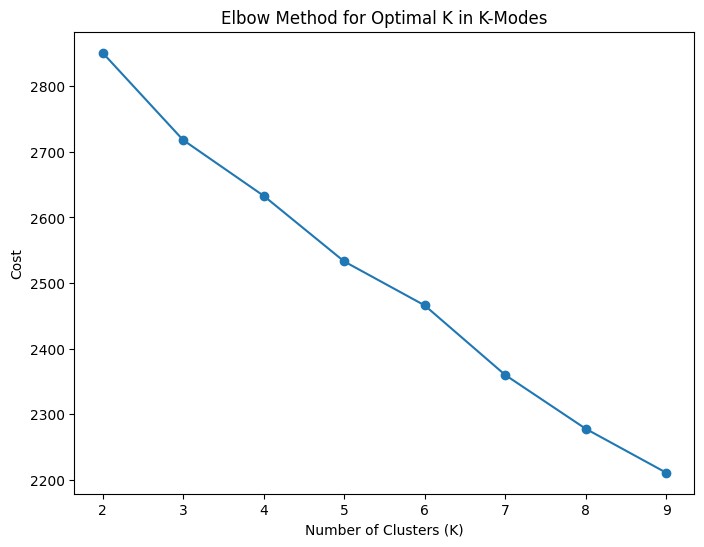

In [3]:
filename_='analytics-case-study-data.csv'
df = pd.read_csv(filename_)  # Replace with your file path
df_cleaned =df.copy()
# df_cleaned = df.dropna(subset=["Opt-In Timestamp"])
df_cleaned["Season_Filtered"] = df_cleaned["Campaign Name"].apply(assign_season)
df_cleaned.loc[:, "Role"] = df_cleaned["Job Title"].apply(categorize_role)
df_cleaned.loc[:, "Region"] = df_cleaned["Country"].apply(categorize_region)
df_cleaned = df_cleaned.drop(columns=["Campaign ID", "Campaign Name", "Account ID", "Account Name", "Prospect ID","Job Title","domain" ,"Opt-In","Country"])



df_=df_cleaned.copy()




df_["Opt-In Timestamp"] = pd.to_datetime(df_["Opt-In Timestamp"], errors="coerce")
df_['Month']=df_["Opt-In Timestamp"].dt.month
df_ = df_.drop(columns=[ "Opt-Out Timestamp","Opt-In Timestamp"])
df_=df_.dropna(subset=["Month"])


X_categorical = df_[["Region", "Prospect Source", "Season_Filtered","Month","Role","Opt-In Source"]]
# Convert categorical values into numerical labels for K-Modes
for col in X_categorical.columns:
    #X_categorical[col] = X_categorical[col].astype("category").cat.codes
    print(f"Mapping for {col}:")
    print(dict(enumerate(X_categorical[col].astype("category").cat.categories)))
    print("-" * 40)
    X_categorical[col] = X_categorical[col].astype("category").cat.codes

# Convert to NumPy array (required by K-Modes)
X_categorical_array = X_categorical.values


# Checks
# unique_values=np.unique(X_categorical_array[:,4])
# print(unique_values)

# Find Optimal K (Number of Clusters)
cost = []
K_range = range(2, 10)  # Trying K from 2 to 10

for k in K_range:
    km = KModes(n_clusters=k, init="Cao", n_init=5, verbose=0)
    km.fit(X_categorical_array)
    cost.append(km.cost_)

# Plot the elbow curve
plt.figure(figsize=(8,6))
plt.plot(K_range, cost, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal K in K-Modes")
plt.show()

In [4]:
# Train K-Modes with optimal K
k_modes = KModes(n_clusters=4, init="Cao", n_init=5, verbose=0)
clusters = k_modes.fit_predict(X_categorical_array)

# Add cluster labels to the original dataset
df_["Cluster"] = clusters

# Display cluster counts
print(df_["Cluster"].value_counts())

Cluster
0    555
1    240
2     96
3     63
Name: count, dtype: int64


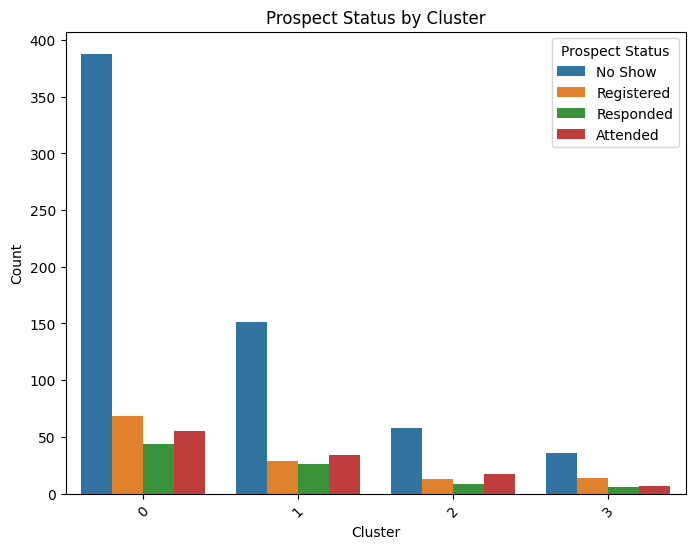

In [5]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_, x="Cluster", hue="Prospect Status")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Prospect Status by Cluster")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Find the most common characteristics for each cluster
cluster_summary = df_.groupby("Cluster")[["Region", "Prospect Source", "Season_Filtered","Opt-In Source"]].agg(pd.Series.mode)
print(cluster_summary)

           Region Prospect Source Season_Filtered            Opt-In Source
Cluster                                                                   
0        Americas   Advertisement     Special Day     online contest entry
1          Europe   Advertisement          Summer    social media campaign
2            Asia   Advertisement            Fall          online purchase
3           LATAM   Advertisement          Spring  newsletter subscription


In [7]:
# df_[(df_["Country"] == "United States") & (df_["Prospect Status"] == "Registered") ].groupby("Cluster").count()
a=b=[]
a=df_[ (df_["Prospect Status"] == "Registered") ].groupby("Cluster")["Prospect Status"].count()
b=df_[ (df_["Region"] == "Americas") & (df_["Prospect Status"] == "Registered") ].groupby("Cluster")["Prospect Status"].count()
merged_df1 = pd.merge(a, b, on="Cluster", how="left")
merged_df1 = (merged_df1.rename(columns={"Prospect Status_x": "Registered", "Prospect Status_y": "From USA"})).fillna(0)
merged_df1

,Registered,From USA
Cluster,,
0,68,41
1,29,4
2,13,1
3,14,1


In [8]:
df_filtered = df_[df_["Prospect Status"] == "Registered"].groupby("Region")["Cluster"].value_counts().unstack()
df_filtered.fillna(0)


Cluster,0,1,2,3
Region,,,,
Americas,41,4,1,1
Asia,9,2,6,1
Europe,13,22,1,1
LATAM,5,1,5,11
